In [ ]:
%matplotlib inline
!pip install opencv-contrib-python==4.3.0.38

""" Forces colab to use the correct version of opencv, sets up matlab, imports
"""

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np

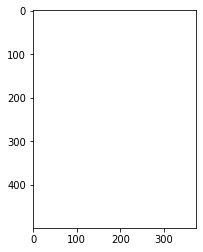

[[ 23.0855  23.0963  18.8194 ...  71.164   25.2179  36.8423]
 [ 22.0964  15.1079  17.8195 ...   6.457    9.979   30.3468]
 [  1.174    1.761   33.8179 ...  10.321   26.797   36.0673]
 ...
 [117.6635  92.894   97.7086 ...  71.0657  97.9212  85.8561]
 [120.184  108.1852 108.1143 ...  81.0647 105.9204 112.8534]
 [111.4237  97.0661  93.0665 ...  96.0632 112.9197 123.8523]]


In [ ]:
"""  This loads the images.  You must first upload the images to your colab
session.  Each time you start a new session, you will need to upload them again.
"""
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

img = mpimg.imread('statue.jpg')     
gray = rgb2gray(img)    
plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()
print(gray)

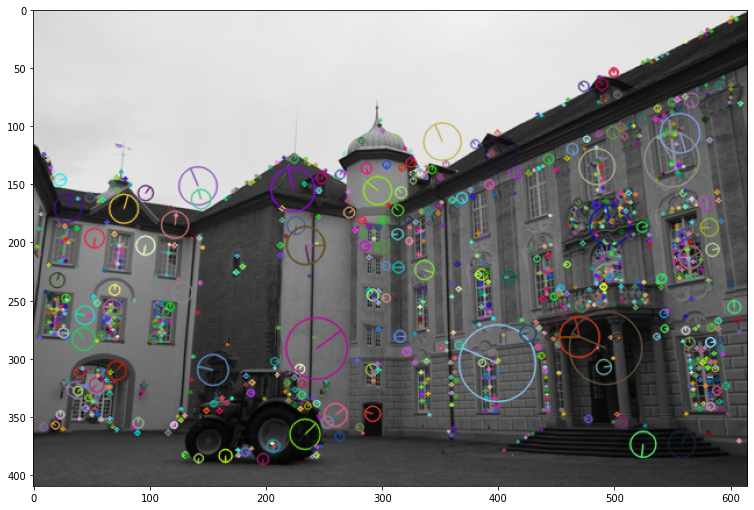

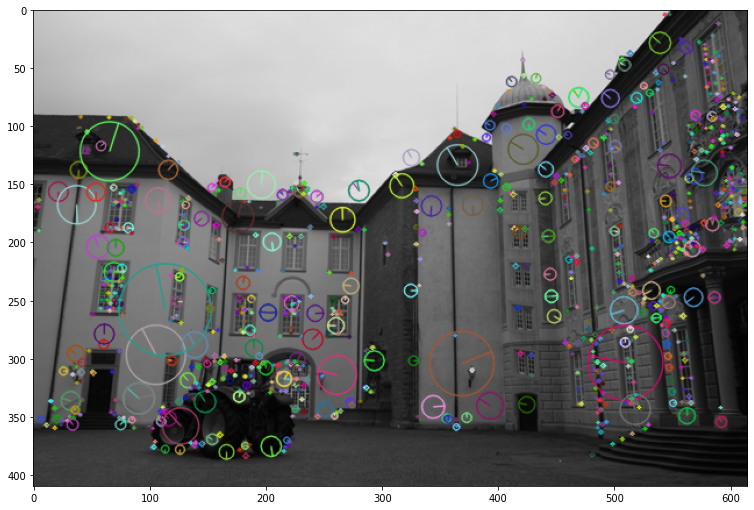

In [ ]:
""" Detects SIFT features in all of the images
"""
keypoints = []
descriptions = []
for im in images:
  gray= cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)

  sift = cv2.xfeatures2d.SIFT_create()
  kp, des = sift.detectAndCompute(gray,None)

  keypoints.append(kp)
  descriptions.append(des)

  plt.figure(figsize=(6.4*2, 4.8*2))
  out_im = cv2.drawKeypoints(gray,kp, gray, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

  plt.imshow(out_im)

num matches 393


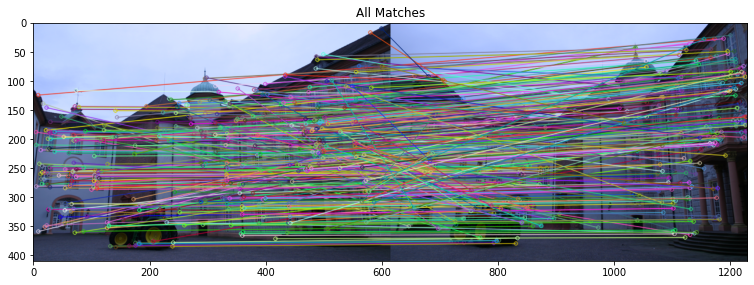

In [ ]:
""" Matches the detected keypoints between the images
"""

bf = cv2.BFMatcher(crossCheck=True)
matches = bf.match(descriptions[0], descriptions[1])

print("num matches", len(matches))


matched_image = cv2.drawMatches(images[0][:, :, ::-1], keypoints[0], images[1][:, :, ::-1], keypoints[1], matches, None, flags=2)
plt.figure(figsize=(6.4*2, 4.8*2))
plt.title("All Matches")
plt.imshow(matched_image)

In [ ]:
""" Compute calibrated coordinates
"""
f = 552
u0 = 307.5
v0 = 205

K = np.array([[f, 0, u0],
              [0, f, v0],
              [0, 0, 1]])


uncalibrated_1 = [[keypoints[0][match.queryIdx].pt[0], keypoints[0][match.queryIdx].pt[1], 1] for match in matches]
uncalibrated_2 = [[keypoints[1][match.trainIdx].pt[0], keypoints[1][match.trainIdx].pt[1], 1] for match in matches]

uncalibrated_1 = np.array(uncalibrated_1).T
uncalibrated_2 = np.array(uncalibrated_2).T

k_inv = np.linalg.inv(K)

calibrated_1 = np.matmul(k_inv, uncalibrated_1).T
calibrated_2 = np.matmul(k_inv, uncalibrated_2).T

In [ ]:
def least_squares_estimation(X1, X2):
  """ YOUR CODE HERE
  """
  a1 = X1[:,0].reshape((X1.shape[0],1)) * X2
  a2 = X1[:,1].reshape((X1.shape[0],1)) * X2
  a3 = X1[:,2].reshape((X1.shape[0],1)) * X2

  A = np.hstack((a1,a2,a3))
  _,_,VT = np.linalg.svd(A)
  V = VT.T

  E = V[:,V.shape[1]-1].reshape((3,3)).T
  U,_,VT = np.linalg.svd(E)
  Diag = np.eye(3)
  Diag[2,2] = 0
  E = U.dot(Diag).dot(VT)
  """ END YOUR CODE
  """
  return E

E_least = least_squares_estimation(calibrated_1, calibrated_2)
print("E least", E_least)

E least [[ 0.03483464  0.19532636  0.00230723]
 [ 0.12138735  0.96929545 -0.08251168]
 [-0.4816593  -0.00994682 -0.87604651]]


E_ransac [[-8.46273171e-04  7.64750119e-02 -1.70721360e-02]
 [-5.29143573e-01 -2.04058027e-02  8.48142712e-01]
 [ 1.18768964e-01 -9.88740290e-01  4.88937047e-02]]
Num inliers (197,)


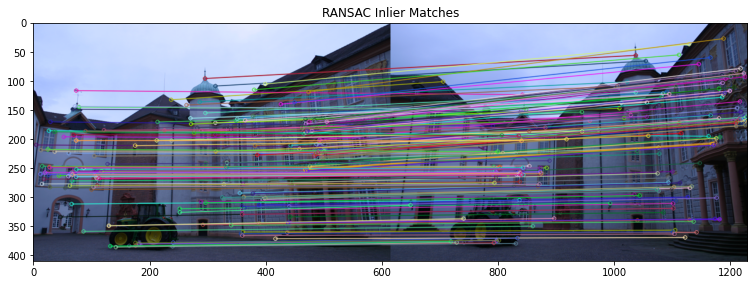

In [ ]:
def ransac_estimator(X1, X2):
  num_iterations = 20000
  sample_size = 8

  eps = 10**-4

  best_num_inliers = -1
  best_inliers = None
  best_E = None

  for _ in range(num_iterations):
    permuted_indices = np.random.permutation (np.arange(X1.shape[0]))
    sample_indices = permuted_indices[:sample_size]
    test_indices = permuted_indices[sample_size:]

    """ YOUR CODE HERE
    """
    # Calculate the sample E
    E = least_squares_estimation(X1[sample_indices,:], X2[sample_indices,:])
    
    # Get the test X1, X2
    RX1 = X1[test_indices,:]
    RX2 = X2[test_indices,:]

    # Calculate the distances of a matching point to the epipolar 
    # Calculate the e_hat
    e = np.array([[0,-1,0],[1,0,0],[0,0,0]])

    # Calculate distance part1
    Ex1 = (E.dot(RX1.T)).T
    nume1 = (np.sum((RX2*Ex1),1)**2).reshape((Ex1.shape[0],1))
    Deno1 = (np.sum((e.dot(Ex1.T))**2,0)).reshape((1,Ex1.shape[0]))
    d1 = nume1.T/Deno1

    # Calculate distance part2
    Ex2 = (RX2.dot(E))
    nume2 = (np.sum((RX1*Ex2),1)**2).reshape((Ex2.shape[0],1))
    Deno2 = (np.sum((e.dot(Ex2.T))**2,0)).reshape((1,Ex2.shape[0]))
    d2 = nume2.T/Deno2

    # Calculate residuals
    resid = d1 + d2
    addpoints = resid < eps
    addpoints = addpoints.reshape((addpoints.shape[1],))
    inliers = np.hstack((sample_indices,test_indices[addpoints]))

    """ END YOUR CODE
    """
    if inliers.shape[0] > best_num_inliers:
      best_num_inliers = inliers.shape[0]
      best_E = E
      best_inliers = inliers


  return best_E, best_inliers
E_ransac, inliers = ransac_estimator(calibrated_1, calibrated_2)
print("E_ransac", E_ransac)
print("Num inliers", inliers.shape)

inlier_matches = [matches[i] for i in inliers]

matched_image = cv2.drawMatches(images[0][:, :, ::-1],
                                keypoints[0],
                                images[1][:, :, ::-1],
                                keypoints[1],
                                inlier_matches, None, flags=2)
plt.figure(figsize=(6.4*2, 4.8*2))
plt.title("RANSAC Inlier Matches")
plt.imshow(matched_image)

In [ ]:
def plot_lines(lines, h, w):
  """ Utility function to plot lines
  """

  for i in range(lines.shape[1]):
    if abs(lines[0, i] / lines[1, i]) < 1:
      y0 = -lines[2, i] / lines[1, i]
      yw = y0 - w * lines[0, i] / lines[1, i]
      plt.plot([0, w], [y0, yw])
    else:
      x0 = -lines[2, i] / lines[0, i]
      xh = x0 - h * lines[1, i] / lines[0, i]
      plt.plot([x0, xh], [0, h])

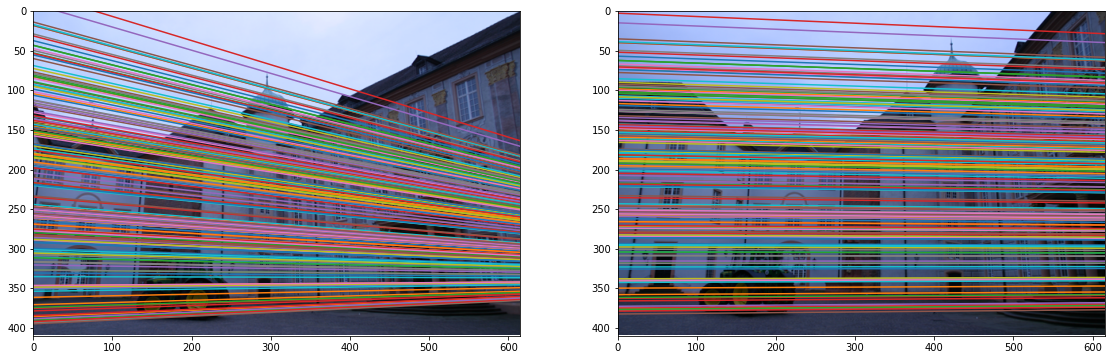

In [ ]:
def plot_epipolar_lines(image1, image2, uncalibrated_1, uncalibrated_2, E, K):
  """ Plots the epipolar lines on the images
  """

  """ YOUR CODE HERE
  """
  # Calculate the fundamental matrix
  F = ((np.linalg.inv(K)).T).dot(E).dot(np.linalg.inv(K))

  # Calculate the epipolar lines

  epipolar_lines_in_1 = ((uncalibrated_2.T).dot(F)).T
  epipolar_lines_in_2 = F.dot(uncalibrated_1)
  """ END YOUR CODE
  """

  plt.figure(figsize=(6.4*3, 4.8*3))
  ax = plt.subplot(1, 2, 1)
  ax.set_xlim([0, image1.shape[1]])
  ax.set_ylim([image1.shape[0], 0])
  plt.imshow(image1[:, :, ::-1])
  plot_lines(epipolar_lines_in_1, image1.shape[0], image1.shape[1])

  ax = plt.subplot(1, 2, 2)
  ax.set_xlim([0, image1.shape[1]])
  ax.set_ylim([image1.shape[0], 0])
  plt.imshow(image2[:, :, ::-1])
  plot_lines(epipolar_lines_in_2, image2.shape[0], image2.shape[1])


uncalibrated_inliers_1 = [[keypoints[0][match.queryIdx].pt[0], keypoints[0][match.queryIdx].pt[1], 1] for match in inlier_matches]
uncalibrated_inliers_2 = [[keypoints[1][match.trainIdx].pt[0], keypoints[1][match.trainIdx].pt[1], 1] for match in inlier_matches]
uncalibrated_inliers_1 = np.array(uncalibrated_inliers_1).T
uncalibrated_inliers_2 = np.array(uncalibrated_inliers_2).T

plot_epipolar_lines(images[0], images[1], uncalibrated_inliers_1, uncalibrated_inliers_2, E_ransac, K)

In [ ]:

transform_canidates = []
canidate = {}
canidate['T'] = np.array([1,2,3])
canidate['R'] = np.array([11,22,33])
transform_canidates.append(canidate)
canidate['T'] = np.array([4,5,6])
canidate['R'] = np.array([44,55,66])
transform_canidates.append(canidate)
R = transform_canidates[1]['R']

In [ ]:
def pose_canidates_from_E(E):
  transform_canidates = []
  """ YOUR CODE HERE
  """
  U,S,VT = np.linalg.svd(E)
  S = np.array([[S[0],0,0],[0,S[1],0],[0,0,S[2]]])
  Rz = np.array([[0,-1,0],[1,0,0],[0,0,1]])

  # Calculate all the possible T hat
  T_h1 = U.dot(Rz).dot(S).dot(U.T);
  T_h2 = U.dot(Rz.T).dot(S).dot(U.T);
  T_h3 = U.dot(Rz).dot(S).dot(U.T);
  T_h4 = U.dot(Rz.T).dot(S).dot(U.T);
  T1 = np.array([T_h1[2,1], T_h1[0,2], T_h1[1,0]]).reshape((3))
  T2 = np.array([T_h2[2,1], T_h2[0,2], T_h2[1,0]]).reshape((3))
  T3 = np.array([T_h3[2,1], T_h3[0,2], T_h3[1,0]]).reshape((3))
  T4 = np.array([T_h4[2,1], T_h4[0,2], T_h4[1,0]]).reshape((3))

  # Calculate all the possible R
  R1 = U.dot(Rz.T).dot(VT)
  R2 = U.dot(Rz).dot(VT)
  R3 = U.dot(Rz).dot(VT)
  R4 = U.dot(Rz.T).dot(VT)

  # Check if the determinant of R is 1 or not
  if np.linalg.det(R1) < 0: 
    T1 = -T1 
    R1 = -R1
  if np.linalg.det(R2) < 0:
    T2 = -T2
    R2 = -R2
  if np.linalg.det(R3) < 0:
    T3 = -T3
    R3 = -R3
  if np.linalg.det(R4) < 0:
    T4 = -T4
    R4 = -R4

  # Store the Values of T and R
  canidate = {}
  canidate['T'] = T1
  canidate['R'] = R1
  transform_canidates.append(canidate)
  canidate = {}
  canidate['T'] = T2
  canidate['R'] = R2
  transform_canidates.append(canidate)
  canidate = {}
  canidate['T'] = T3
  canidate['R'] = R3
  transform_canidates.append(canidate)
  canidate = {}
  canidate['T'] = T4
  canidate['R'] = R4
  transform_canidates.append(canidate)

  """ END YOUR CODE
  """
  return transform_canidates



transform_canidates = pose_canidates_from_E(E_ransac)
print("transform_canidates", transform_canidates)

transform_canidates [{'T': array([-0.99692497, -0.01564044, -0.07678527]), 'R': array([[ 0.88008319,  0.11270736,  0.46124899],
       [-0.10532796,  0.9935583 , -0.04180813],
       [-0.46298985, -0.01178779,  0.88628519]])}, {'T': array([0.99692497, 0.01564044, 0.07678527]), 'R': array([[ 0.79510712,  0.14050228,  0.5899693 ],
       [ 0.13160949, -0.98958578,  0.05830036],
       [ 0.59201656,  0.03129053, -0.80531813]])}, {'T': array([-0.99692497, -0.01564044, -0.07678527]), 'R': array([[ 0.79510712,  0.14050228,  0.5899693 ],
       [ 0.13160949, -0.98958578,  0.05830036],
       [ 0.59201656,  0.03129053, -0.80531813]])}, {'T': array([0.99692497, 0.01564044, 0.07678527]), 'R': array([[ 0.88008319,  0.11270736,  0.46124899],
       [-0.10532796,  0.9935583 , -0.04180813],
       [-0.46298985, -0.01178779,  0.88628519]])}]


In [ ]:
def plot_reconstruction(P1, P2, T, R):

  # P1trans = np.add((R .dot (P1.T)).T,T.T)
  P1trans = (R @ P1.T).T + T

  plt.figure(figsize=(6.4*2, 4.8*2))
  ax = plt.axes()
  ax.set_xlabel('x')
  ax.set_ylabel('z')
  plt.plot([0], [0], 'bs')
  plt.plot([T[0]], [T[2]], 'ro')

  for i in range(P1.shape[0]):
    plt.plot([0, P2[i, 0]], [0, P2[i, 2]], 'bs-')
    plt.plot([T[0], P1trans[i, 0]], [T[2], P1trans[i, 2]], 'ro-')

best 371 (393,)
not best 0
not best 1
not best 21


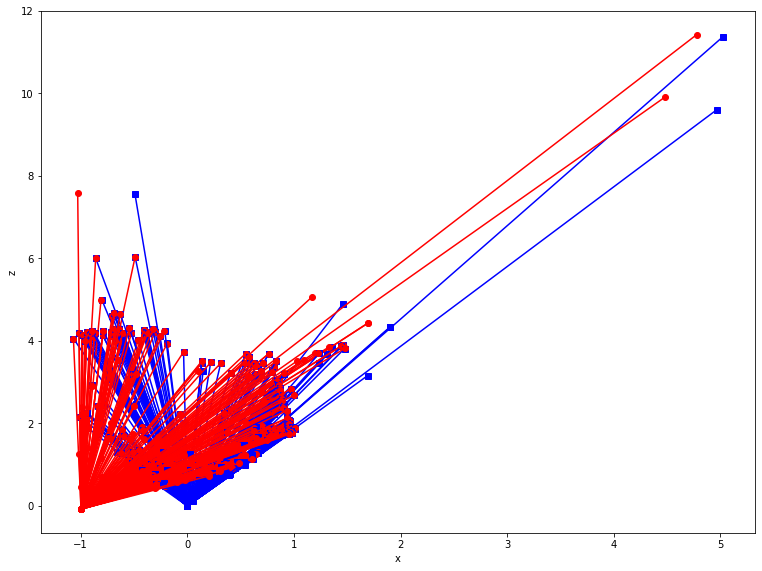

In [ ]:
def reconstruct3D(transform_canidates, calibrated_1, calibrated_2):
  """This functions selects (T,R) among the 4 candidates transform_candidates
  such that all triangulated points are in front of both cameras.
  """

  best_num_front = -1
  best_canidate = None
  best_lambdas = None
  for canidate in transform_canidates:
    R = canidate['R']
    T = canidate['T']

    lambdas = np.zeros((2, calibrated_1.shape[0]))
    """ YOUR CODE HERE
    """
    for i in range(calibrated_1.shape[0]):
      qi = calibrated_2[i,:].reshape((3,1))
      Rpi = R.dot(calibrated_1[i,:].reshape((3,1)))
      lambdas[:,i] = (np.linalg.pinv(np.hstack((qi,-Rpi))).dot(T/np.linalg.norm(T.T))).reshape((2,))

      if any(lambdas[:,i]<0):
        lambdas[:,i] = np.zeros((2,1)).reshape((2,))

    """ END YOUR CODE
    """
    num_front = np.sum(np.logical_and(lambdas[0]>0, lambdas[1]>0))

    if num_front > best_num_front:
      best_num_front = num_front
      best_canidate = canidate
      best_lambdas = lambdas
      print("best", num_front, best_lambdas[0].shape)
    else:
      print("not best", num_front)


  P1 = best_lambdas[1].reshape(-1, 1) * calibrated_1
  P2 = best_lambdas[0].reshape(-1, 1) * calibrated_2
  T = best_canidate['T']
  R = best_canidate['R']
  return P1, P2, T, R


P1, P2, T, R = reconstruct3D(transform_canidates, calibrated_1, calibrated_2)


plot_reconstruction(P1, P2, T, R)

In [ ]:
print(K)

[[552.    0.  307.5]
 [  0.  552.  205. ]
 [  0.    0.    1. ]]


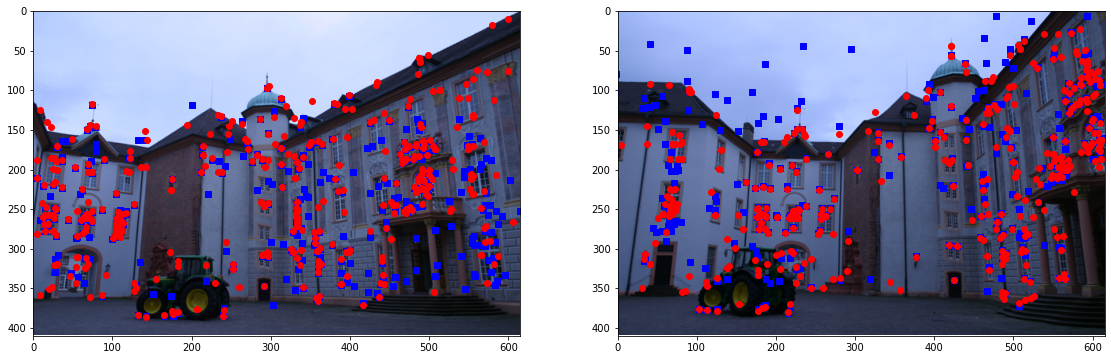

In [ ]:
def show_reprojections(image1, image2, uncalibrated_1, uncalibrated_2, P1, P2, K, T, R):

  """ YOUR CODE HERE
  """
  P2proj = (np.dot(np.dot(K,R.T),(P2-T).T)).T
  P1proj = (np.dot(K,(np.dot(R,P1.T).T+T).T)).T
  """ END YOUR CODE
  """


  plt.figure(figsize=(6.4*3, 4.8*3))
  ax = plt.subplot(1, 2, 1)
  ax.set_xlim([0, image1.shape[1]])
  ax.set_ylim([image1.shape[0], 0])
  plt.imshow(image1[:, :, ::-1])
  plt.plot(P2proj[:, 0] / P2proj[:, 2],
           P2proj[:, 1] / P2proj[:, 2], 'bs')
  plt.plot(uncalibrated_1[0, :], uncalibrated_1[1, :], 'ro')

  ax = plt.subplot(1, 2, 2)
  ax.set_xlim([0, image1.shape[1]])
  ax.set_ylim([image1.shape[0], 0])
  plt.imshow(image2[:, :, ::-1])
  plt.plot(P1proj[:, 0] / P1proj[:, 2],
           P1proj[:, 1] / P1proj[:, 2], 'bs')
  plt.plot(uncalibrated_2[0, :], uncalibrated_2[1, :], 'ro')

show_reprojections(images[0], images[1], uncalibrated_1, uncalibrated_2, P1, P2, K, T, R)